In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
import cv2

# 生成包含星状位移场的散斑图

In [2]:
def star_displacement(RG, pmax=120, pmin=30):
    # 星状位移场
    # pmax控制最左端的条纹数目 pmin最右端的条纹数目
    H, L = RG.shape;
    x = np.arange(L)
    y = np.arange(H)
    X, Y = np.meshgrid(x, y)
    pwave=pmin+X*(pmax-pmin)/L
    v1 = 0.5*np.cos((Y-H/2)*2*np.pi/(pwave))
    # 计算矩阵的最小值和最大值
    min_val = np.min(v1)
    max_val = np.max(v1)
    # 归一化矩阵到[-1, 1]范围
    v = 2 * (v1 - min_val) / (max_val - min_val) - 1
    return v

def generate_fig(RG, pmax, pmin):
    H, L = RG.shape;
    x = np.arange(L)
    y = np.arange(H)
    X, Y = np.meshgrid(x, y)
    #%% 控制最左端的条纹数目 和 最右端的条纹数目
    v = star_displacement(RG, pmax, pmin)
    x_list = np.linspace(-1, 1, L)
    y_list = np.linspace(-1, 1, H)
    X, Y = np.meshgrid(x_list, y_list)
    # 创建插值后的新采样点
    displacement_field_u = np.zeros_like(v)
    displacement_field_v = v
    X_new = X + displacement_field_u/L
    Y_new = Y + displacement_field_v/H
    # 转换为PyTorch张量
    X_new_tensor = torch.tensor(X_new, dtype=torch.float32)
    Y_new_tensor = torch.tensor(Y_new, dtype=torch.float32)
    RG_tensor = torch.tensor(RG, dtype=torch.float32)
    # 执行双线性插值
    interpolated_RG = F.grid_sample(RG_tensor.unsqueeze(0).unsqueeze(0), 
                                    torch.stack((X_new_tensor, Y_new_tensor), dim=2).unsqueeze(0), 
                                    mode='bilinear', align_corners=True)
    # 得到插值后的变形散斑图像
    DG = interpolated_RG[0, 0].view(256,-1).numpy()
    DG = np.clip(DG, 0, 255)
    return DG

(-0.5, 511.5, 255.5, -0.5)

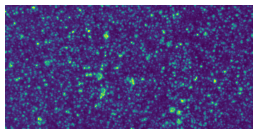

In [3]:
fig_path = '../Data/Speckle_image/simulation_experiment/star_displacement/Star_RG_256X1024_120_15.bmp'
ref_image = Image.open(fig_path)
ref_gray = ref_image.convert('L')
ref_gray = np.array(ref_gray)
RG = ref_gray[:,0:512]
cv2.imwrite('./speckle figure/RG.bmp', RG)
plt.figure(dpi=50)
plt.imshow(RG)
plt.axis('off')

In [20]:
# pmax = [76.0, 77.0, 78.0, 79.0, 80.0]
pmax = [76.0, 76.2, 76.4, 76.6, 76.8]
pmax.reverse()
pmin = [16.0, 16.2, 16.4, 16.6, 16.8]
pmin.reverse()
H, W = RG.shape
v_list = np.zeros((len(pmax), H, W))
for i in range(len(pmax)):
    DG = generate_fig(RG, pmax[i], pmin[i])
    cv2.imwrite(f'./speckle figure/DG{i}.bmp', DG)

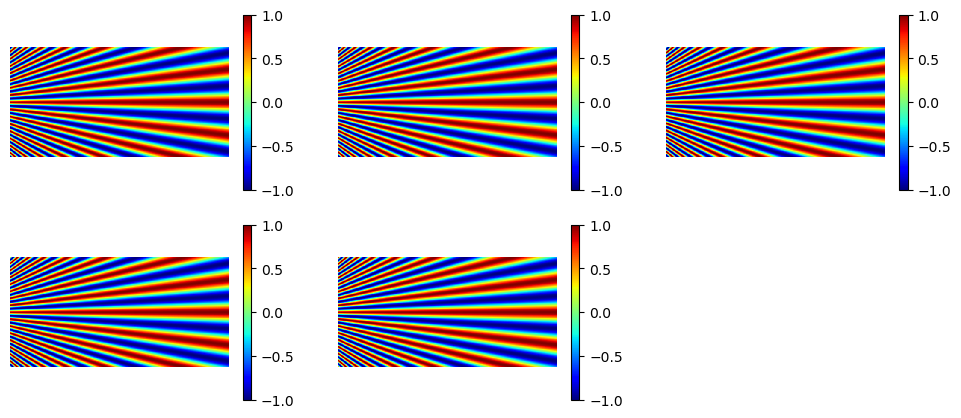

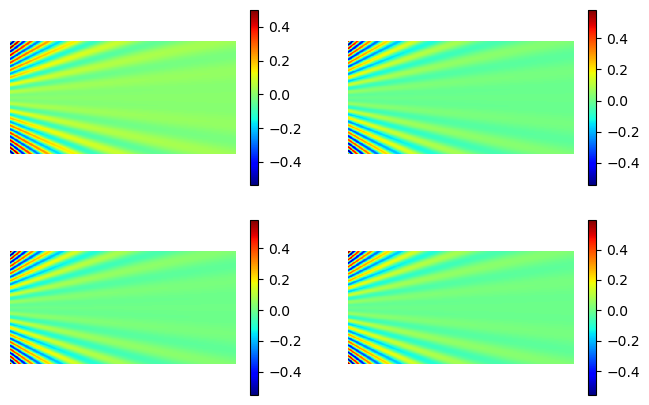

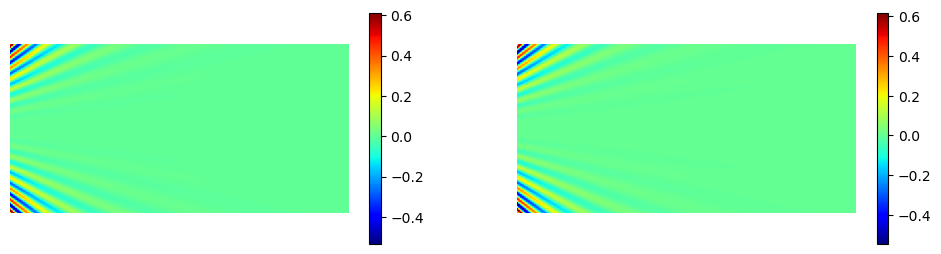

In [24]:
for i in range(len(pmax)):
    v_list[i] = star_displacement(RG, pmax[i], pmin[i])
images = []
plt.figure(figsize=(12, 5))
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.imshow(v_list[i], cmap='jet', interpolation='nearest', norm=norm) # +b[0,1]
    plt.axis('off')
    plt.colorbar()

plt.figure(figsize=(8, 5))
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(v_list[i+1]-v_list[i], cmap='jet', interpolation='nearest') # +b[0,1]
    plt.axis('off')
    plt.colorbar()

plt.figure(figsize=(12, 3))
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow((v_list[i+3]-v_list[i+2])-(v_list[i+1]-v_list[i]), cmap='jet', interpolation='nearest') # +b[0,1]
    plt.axis('off')
    plt.colorbar()

# 生成包含线性变化位移场的散斑图

In [11]:
def UT_displacement(RG, k):
    H, L = RG.shape;
    x_list = np.linspace(-1, 1, L)
    y_list = np.linspace(-1, 1, H)
    u, v = np.meshgrid(x_list, y_list)
    u = u * k; v = v * k
    return u, v

def generate_fig(RG, k):
    u, v = UT_displacement(RG, k)
    H, L = RG.shape;
    x_list = np.linspace(-1, 1, L)
    y_list = np.linspace(-1, 1, H)
    X, Y = np.meshgrid(x_list, y_list)
    # 创建插值后的新采样点
    displacement_field_u = u
    displacement_field_v = v
    X_new = X + displacement_field_u/L
    Y_new = Y + displacement_field_v/H
    # 转换为PyTorch张量
    X_new_tensor = torch.tensor(X_new, dtype=torch.float32)
    Y_new_tensor = torch.tensor(Y_new, dtype=torch.float32)
    RG_tensor = torch.tensor(RG, dtype=torch.float32)
    # 执行双线性插值
    interpolated_RG = F.grid_sample(RG_tensor.unsqueeze(0).unsqueeze(0), 
                                    torch.stack((X_new_tensor, Y_new_tensor), dim=2).unsqueeze(0), 
                                    mode='bilinear', align_corners=True)
    # 得到插值后的变形散斑图像
    DG = interpolated_RG[0, 0].view(256,-1).numpy()
    DG = np.clip(DG, 0, 255)
    return DG

(-0.5, 511.5, 255.5, -0.5)

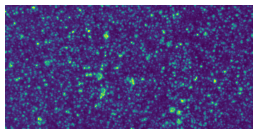

In [9]:
fig_path = '../Data/Speckle_image/simulation_experiment/star_displacement/Star_RG_256X1024_120_15.bmp'
ref_image = Image.open(fig_path)
ref_gray = ref_image.convert('L')
ref_gray = np.array(ref_gray)
RG = ref_gray[:,0:512]
cv2.imwrite('./speckle figure/RG.bmp', RG)
plt.figure(dpi=50)
plt.imshow(RG)
plt.axis('off')

In [22]:
k_list = [1.0, 0.9, 0.8, 0.7, 0.6]
k_list.reverse()
H, W = RG.shape
u_list = np.zeros((len(k_list), H, W))
v_list = np.zeros((len(k_list), H, W))
for i in range(len(k_list)):
    DG = generate_fig(RG, k_list[i])
    cv2.imwrite(f'./speckle figure/DG{i}.bmp', DG)

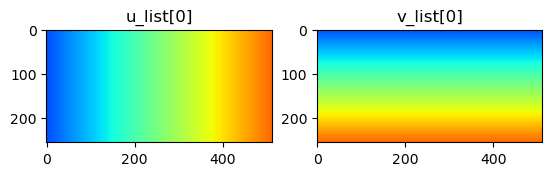

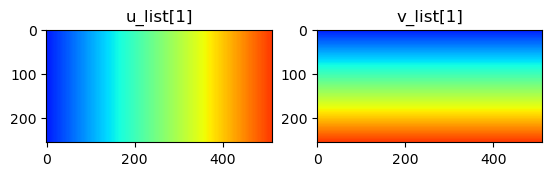

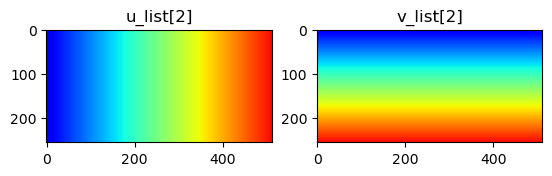

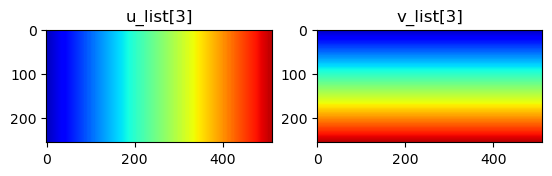

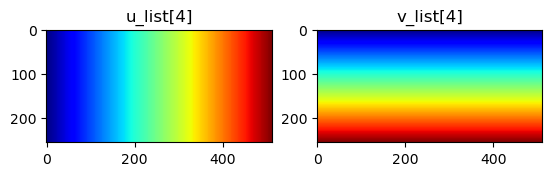

In [18]:
for i in range(len(k_list)):
    u_list[i], v_list[i] = UT_displacement(RG, k_list[i])

for i in range(len(k_list)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    # 第一个子图显示 u_list[i]
    ax1.imshow(u_list[i], cmap='jet', interpolation='nearest', norm=norm)
    ax1.set_title('u_list[{}]'.format(i))
    # 第二个子图显示 v_list[i]
    ax2.imshow(v_list[i], cmap='jet', interpolation='nearest', norm=norm)
    ax2.set_title('v_list[{}]'.format(i))
    # 显示图形
    plt.show()

# 生成包含刚体位移场的散斑图

In [23]:
def rigid_displacement(RG, k):
    H, L = RG.shape;
    u = np.zeros_like(RG)
    v = np.ones_like(RG)
    u = u * k; v = v * k
    return u, v

def generate_fig(RG, k):
    u, v = rigid_displacement(RG, k)
    H, L = RG.shape;
    x_list = np.linspace(-1, 1, L)
    y_list = np.linspace(-1, 1, H)
    X, Y = np.meshgrid(x_list, y_list)
    # 创建插值后的新采样点
    displacement_field_u = u
    displacement_field_v = v
    X_new = X + displacement_field_u/L
    Y_new = Y + displacement_field_v/H
    # 转换为PyTorch张量
    X_new_tensor = torch.tensor(X_new, dtype=torch.float32)
    Y_new_tensor = torch.tensor(Y_new, dtype=torch.float32)
    RG_tensor = torch.tensor(RG, dtype=torch.float32)
    # 执行双线性插值
    interpolated_RG = F.grid_sample(RG_tensor.unsqueeze(0).unsqueeze(0), 
                                    torch.stack((X_new_tensor, Y_new_tensor), dim=2).unsqueeze(0), 
                                    mode='bilinear', align_corners=True)
    # 得到插值后的变形散斑图像
    DG = interpolated_RG[0, 0].view(256,-1).numpy()
    DG = np.clip(DG, 0, 255)
    return DG

(-0.5, 511.5, 255.5, -0.5)

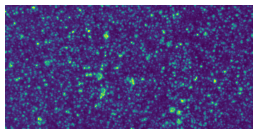

In [24]:
fig_path = '../Data/Speckle_image/simulation_experiment/star_displacement/Star_RG_256X1024_120_15.bmp'
ref_image = Image.open(fig_path)
ref_gray = ref_image.convert('L')
ref_gray = np.array(ref_gray)
RG = ref_gray[:,0:512]
cv2.imwrite('./speckle figure/RG.bmp', RG)
plt.figure(dpi=50)
plt.imshow(RG)
plt.axis('off')

In [25]:
k_list = [1.0, 0.9, 0.8, 0.7, 0.6]
k_list.reverse()
H, W = RG.shape
u_list = np.zeros((len(k_list), H, W))
v_list = np.zeros((len(k_list), H, W))
for i in range(len(k_list)):
    DG = generate_fig(RG, k_list[i])
    cv2.imwrite(f'./speckle figure/DG{i}.bmp', DG)

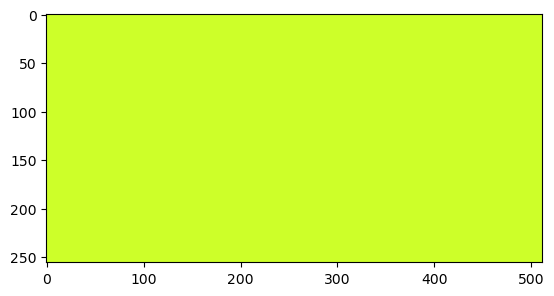

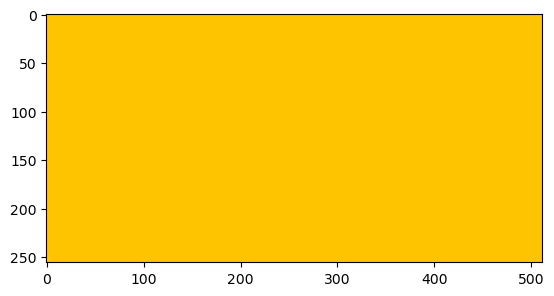

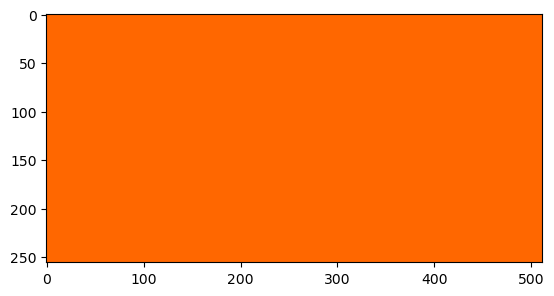

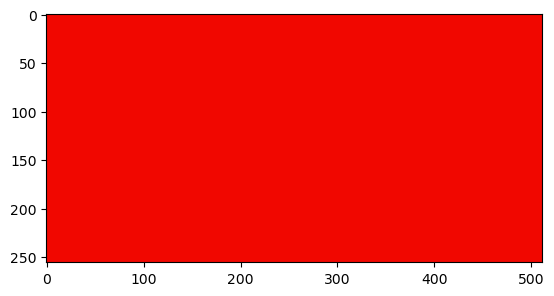

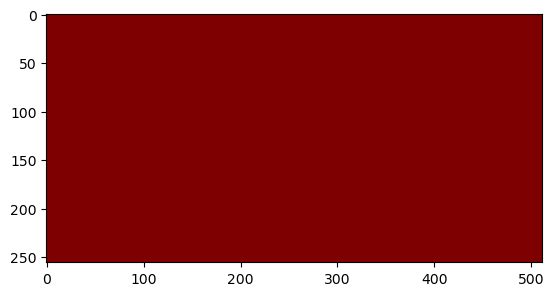

In [26]:
for i in range(len(k_list)):
    u_list[i], v_list[i] = rigid_displacement(RG, k_list[i])
for i in range(len(k_list)):
    # 绘制图像
    fig, ax = plt.subplots()
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    ax.imshow(v_list[i], cmap='jet', interpolation='nearest', norm=norm)